# Pytorch模型加载

## 加载所需要的库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from imageio import imread
from tqdm import tqdm
from PIL import Image,ImageDraw

import torch
from torch import nn
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim

import os
import sys
import struct
import time
import json
from pynq import Overlay
from pynq import allocate

## 定义网络

In [2]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        self.featurs = features
        self.classifier = nn.Sequential(
                                        nn.Linear(512 * 7 * 7, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(4096, num_classes)
                                        )

          # 初始化参数
        if init_weights:
            self._initialize_weights()

    
    def forward(self, x):
        # N x 3 X 224 x224
        x = self.featurs(x)
        # N x 512 x 7 x 7
        x = torch.flatten(x, start_dim=1)
        # N x 512*7*7
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():  # 变量网络所有层
            if isinstance(m, nn.Conv2d):  # 是否为卷积层
              # 使用Kaiming初始化方法来初始化该层的权重
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # 否具有偏差项
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):  # 是否为Linear
                # 正太分布初始化全连接层
                nn.init.normal_(m.weight, 0, 0.01)
                # 将偏项设置为0
                nn.init.constant_(m.bias, 0)
                

In [3]:
def make_features(cfg: list):
    # 创建一个空列表用于存储神经网络的不同层
    layers = []
    # 初始输入通道数
    in_channels = 3
    # 遍历传入的配置列表
    for v in cfg:
        if v == "M":  # 池化层3
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:  # 卷积层
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            # 更新输入通道数，以便下一层的卷积层使用
            in_channels = v
    # 返回一个包含所有层的顺序容器，通常是一个特征提取器部分
    return nn.Sequential(*layers)


    # 定义了不同VGG模型的卷积配置信息，其中 'M' 表示池化层，数字表示卷积层的输出通道数
cfgs = {
'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


In [4]:
# 定义一个函数 vgg，用于构建不同类型的VGG神经网络模型
def vgg(model_name="vgg16", **kwargs):
    # 检查传入的模型名是否在配置字典中
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    # 根据模型名获取对应的卷积配置信息
    cfg = cfgs[model_name]

    # 使用 make_features 函数创建特征提取器，然后将其传递给 VGG 模型
    model = VGG(make_features(cfg), **kwargs)
    return model

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [67]:
import time

In [123]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载图片
img_path = 'sunflower.jpg'
assert os.path.exists(img_path), "file: '{}' does not exist.".format(img_path)
image = Image.open(img_path)

# img.show()
# image.show()
# [N, C, H, W]
start_time = time.time()
img = data_transform(image)
print(time.time()-start_time)
# 扩展维度
img = torch.unsqueeze(img, dim=0)

0.012840509414672852


In [8]:
img[0,:,0,5]

tensor([0.4745, 0.5843, 0.7882])

## 加载模型

In [9]:
# 获取标签
json_path = 'class_indices.json'
assert os.path.exists(json_path), "file: '{}' does not exist.".format(json_path)
with open(json_path, 'r') as f:
    # 使用json.load()函数加载JSON文件的内容并将其存储在一个Python字典中
    class_indict = json.load(f)

# 加载网络
model = vgg(model_name="vgg16", num_classes=5).to(device)

# 加载模型文件
weights_path = "./vgg16Net.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path,map_location="cpu"))

model.eval()

VGG(
  (featurs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

## 进行一张图片的推理

6.491859197616577
class: daisy        prob: 0.000283
class: dandelion    prob: 0.017
class: roses        prob: 0.000757
class: sunflowers   prob: 0.978
class: tulips       prob: 0.00418


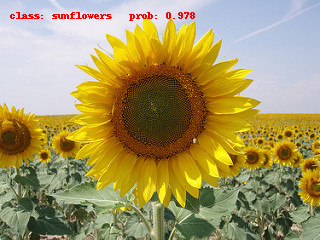

In [10]:
with torch.no_grad():
    # 对输入图像进行预测
    t = time.time()
    output = torch.squeeze(model.forward(img)).cpu()
    print(time.time()-t)
    # 对模型的输出进行 softmax 操作，将输出转换为类别概率
    predict = torch.softmax(output, dim=0)
    # 得到高概率的类别的索引
    predict_cla = torch.argmax(predict).numpy()

res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)], predict[predict_cla].numpy())
draw = ImageDraw.Draw(image)
# 文本的左上角位置
position = (10, 10)
# fill 指定文本颜色
draw.text(position, res, fill='red')
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)], predict[i].numpy()))
image

## 保存卷积层权重到npy中

In [11]:
# np.save('conv1_w.npy', np.int16(model.featurs[0].weight.data*pow(2,10)))
# np.save('conv2_w.npy', np.int16(model.featurs[2].weight.data*pow(2,10)))
# np.save('conv5_w.npy', np.int16(model.featurs[5].weight.data*pow(2,10)))
# np.save('conv7_w.npy', np.int16(model.featurs[7].weight.data*pow(2,10)))
# np.save('conv10_w.npy', np.int16(model.featurs[10].weight.data*pow(2,10)))
# np.save('conv12_w.npy', np.int16(model.featurs[12].weight.data*pow(2,10)))
# np.save('conv14_w.npy', np.int16(model.featurs[14].weight.data*pow(2,10)))
# np.save('conv17_w.npy', np.int16(model.featurs[17].weight.data*pow(2,10)))
# np.save('conv19_w.npy', np.int16(model.featurs[19].weight.data*pow(2,10)))
# np.save('conv21_w.npy', np.int16(model.featurs[21].weight.data*pow(2,10)))
# np.save('conv24_w.npy', np.int16(model.featurs[24].weight.data*pow(2,10)))
# np.save('conv26_w.npy', np.int16(model.featurs[26].weight.data*pow(2,10)))
# np.save('conv28_w.npy', np.int16(model.featurs[28].weight.data*pow(2,10)))

In [12]:
# np.save('conv1_b.npy', np.int16(model.featurs[0].bias.data*pow(2,10)))
# np.save('conv2_b.npy', np.int16(model.featurs[2].bias.data*pow(2,10)))
# np.save('conv5_b.npy', np.int16(model.featurs[5].bias.data*pow(2,10)))
# np.save('conv7_b.npy', np.int16(model.featurs[7].bias.data*pow(2,10)))
# np.save('conv10_b.npy', np.int16(model.featurs[10].bias.data*pow(2,10)))
# np.save('conv12_b.npy', np.int16(model.featurs[12].bias.data*pow(2,10)))
# np.save('conv14_b.npy', np.int16(model.featurs[14].bias.data*pow(2,10)))
# np.save('conv17_b.npy', np.int16(model.featurs[17].bias.data*pow(2,10)))
# np.save('conv19_b.npy', np.int16(model.featurs[19].bias.data*pow(2,10)))
# np.save('conv21_b.npy', np.int16(model.featurs[21].bias.data*pow(2,10)))
# np.save('conv24_b.npy', np.int16(model.featurs[24].bias.data*pow(2,10)))
# np.save('conv26_b.npy', np.int16(model.featurs[26].bias.data*pow(2,10)))
# np.save('conv28_b.npy', np.int16(model.featurs[28].bias.data*pow(2,10)))

# PYNQ部分 卷积层

In [11]:
from pynq import Overlay
from pynq import allocate
import numpy as np
import time
ol=Overlay("HardWare/cnn8.bit")
ol.ip_dict
ol.download()
conv=ol.My_Conv_0
dense=ol.Dense_0
print("Overlay download finish");

Overlay download finish


## 图像处理+卷积加速

In [13]:
from pynq import Overlay
from pynq import allocate
import numpy as np
import time
ol=Overlay("HardWare/full2.bit")
ol.ip_dict
ol.download()
conv=ol.My_Conv_0
dense=ol.Dense_0

time_now = time.time()
ol.download()
print(time.time()-time_now)

print("Overlay download finish");

2.1354334354400635
Overlay download finish


## 定义硬件接口

In [14]:
# 1028 pool
def RunConv(conv,CHin,In_Height,In_Width,CHout,Kx,Ky,Sx,Sy,mode,relu_en,layer,feature_in,W,bias,feature_out):
    conv.write(0x10,CHin);
    conv.write(0x18,In_Height);
    conv.write(0x20,In_Width);
    conv.write(0x28,CHout);
    conv.write(0x30,Kx);
    conv.write(0x38,Ky);
    conv.write(0x40,Sx);
    conv.write(0x48,Sy);
    conv.write(0x50,mode);
    conv.write(0x58,relu_en);
    conv.write(0x60,layer);
    conv.write(0x68,feature_in.physical_address);
    conv.write(0x74,feature_in.physical_address);
    conv.write(0x80,feature_in.physical_address);
    conv.write(0x8c,feature_in.physical_address);
    conv.write(0x98,W.physical_address);
    conv.write(0xa4,W.physical_address);
    conv.write(0xb0,W.physical_address);
    conv.write(0xbc,W.physical_address);
    conv.write(0xc8,bias.physical_address);
    conv.write(0xd4,feature_out.physical_address);
    conv.write(0xe0,feature_out.physical_address);
    conv.write(0xec,feature_out.physical_address);
    conv.write(0xf8,feature_out.physical_address);
    conv.write(0, (conv.read(0)&0x80)|0x01 );
    tp=conv.read(0)
    while not ((tp>>1)&0x1):
        tp=conv.read(0);

In [15]:
def Load_Weight(Weight_Buf,Weight):
    Weight_Buf[:Weight.flatten().shape[0]] = Weight.flatten()
def Load_Bias(Bias_Buf,bias):
     Bias_Buf[:bias.flatten().shape[0]] = bias.flatten()
def Load_Img(img_buf,img_np):
     img_buf[:img_np.flatten().shape[0]] = img_np.flatten()

In [16]:
def RunDense(dense,CHin,CHout,relu_en,feature_in,W,bias,feature_out):
    dense.write(0x10,CHin);
    dense.write(0x18,CHout);
    dense.write(0x20,relu_en);
    dense.write(0x28,feature_in.physical_address);
    dense.write(0x34,W.physical_address);
    dense.write(0x40,W.physical_address);
    dense.write(0x4c,W.physical_address);
    dense.write(0x58,W.physical_address);
    dense.write(0x64,bias.physical_address);
    dense.write(0x70,feature_out.physical_address);
    
    dense.write(0, (dense.read(0)&0x80)|0x01 );
    tp=dense.read(0)
    while not ((tp>>1)&0x1):
        tp=dense.read(0);

## 各层的参数

In [17]:
from layers import *

## 定义输入输出buf

In [18]:
feature_buf1=allocate(shape=(2048*64*64),cacheable=1,dtype=np.int16)
feature_buf2=allocate(shape=(2048*64*64),cacheable=1,dtype=np.int16)

## 定义卷积层参数buf

In [19]:
W_conv1=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv2=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv5=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv7=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv10=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv12=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv14=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv17=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv19=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv21=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv24=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv26=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)
W_conv28=allocate(shape=(1024*1024*3*3),cacheable=1,dtype=np.int16)

b_conv1=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv2=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv5=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv7=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv10=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv12=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv14=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv17=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv19=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv21=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv24=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv26=allocate(shape=(1024),cacheable=1,dtype=np.int16)
b_conv28=allocate(shape=(1024),cacheable=1,dtype=np.int16)

## 定义全连接层共享DDR区

In [20]:
#权重
dense0_w=allocate(shape=(25088*5000),cacheable=1,dtype=np.int16)
dense3_w=allocate(shape=(4096*4096),cacheable=1,dtype=np.int16)
dense6_w=allocate(shape=(4096*5),cacheable=1,dtype=np.int16)

#偏置
dense0_b=allocate(shape=(4096),cacheable=1,dtype=np.int16)
dense3_b=allocate(shape=(4096),cacheable=1,dtype=np.int16)
dense6_b=allocate(shape=(4096),cacheable=1,dtype=np.int16)

## 加载卷积层权重

In [21]:
conv1_w = np.load("conv1_w.npy")
conv2_w = np.load("conv2_w.npy")
conv5_w = np.load("conv5_w.npy")
conv7_w = np.load("conv7_w.npy")
conv10_w = np.load("conv10_w.npy")
conv12_w = np.load("conv12_w.npy")
conv14_w = np.load("conv14_w.npy")
conv17_w = np.load("conv17_w.npy")
conv19_w = np.load("conv19_w.npy")
conv21_w = np.load("conv21_w.npy")
conv24_w = np.load("conv24_w.npy")
conv26_w = np.load("conv26_w.npy")
conv28_w = np.load("conv28_w.npy")

In [22]:
conv1_b= np.load("conv1_b.npy")
conv2_b= np.load("conv2_b.npy")
conv5_b= np.load("conv5_b.npy")
conv7_b= np.load("conv7_b.npy")
conv10_b= np.load("conv10_b.npy")
conv12_b= np.load("conv12_b.npy")
conv14_b= np.load("conv14_b.npy")
conv17_b= np.load("conv17_b.npy")
conv19_b= np.load("conv19_b.npy")
conv21_b= np.load("conv21_b.npy")
conv24_b= np.load("conv24_b.npy")
conv26_b= np.load("conv26_b.npy")
conv28_b= np.load("conv28_b.npy")

In [23]:
Load_Weight(W_conv1,conv1_w)
Load_Weight(W_conv2,conv2_w)
Load_Weight(W_conv5,conv5_w)
Load_Weight(W_conv7,conv7_w)
Load_Weight(W_conv10,conv10_w)
Load_Weight(W_conv12,conv12_w)
Load_Weight(W_conv14,conv14_w)
Load_Weight(W_conv17,conv17_w)
Load_Weight(W_conv19,conv19_w)
Load_Weight(W_conv21,conv21_w)
Load_Weight(W_conv24,conv24_w)
Load_Weight(W_conv26,conv26_w)
Load_Weight(W_conv28,conv28_w)

Load_Bias(b_conv1,conv1_b)
Load_Bias(b_conv2,conv2_b)
Load_Bias(b_conv5,conv5_b)
Load_Bias(b_conv7,conv7_b)
Load_Bias(b_conv10,conv10_b)
Load_Bias(b_conv12,conv12_b)
Load_Bias(b_conv14,conv14_b)
Load_Bias(b_conv17,conv17_b)
Load_Bias(b_conv19,conv19_b)
Load_Bias(b_conv21,conv21_b)
Load_Bias(b_conv24,conv24_b)
Load_Bias(b_conv26,conv26_b)
Load_Bias(b_conv28,conv28_b)

## 加载全连接层参数

In [24]:
dense0_w_np = np.load("dense0_w.npy")
dense3_w_np = np.load("dense3_w.npy")
dense6_w_np = np.load("dense6_w.npy")

dense0_b_np = np.load("dense0_b.npy")
dense3_b_np = np.load("dense3_b.npy")
dense6_b_np = np.load("dense6_b.npy")

In [25]:
Load_Weight(dense0_w,dense0_w_np)
Load_Weight(dense3_w,dense3_w_np)
Load_Weight(dense6_w,dense6_w_np)

Load_Bias(dense0_b,dense0_b_np)
Load_Bias(dense3_b,dense3_b_np)
Load_Bias(dense6_b,dense6_b_np)

# 图像预处理模块

In [26]:
# 312 resize
def RunIP(resize,Img_In,Img_Out,rows_in,cols_in,rows_out,cols_out):
    resize.write(0x10,Img_In.physical_address);
    resize.write(0x1c,Img_Out.physical_address);
    resize.write(0x28,rows_in);
    resize.write(0x30,cols_in);
    resize.write(0x38,rows_out);
    resize.write(0x40,cols_out);
    
    resize.write(0, (resize.read(0)&0x80)|0x01 );
    tp=resize.read(0)
    while not ((tp>>1)&0x1):
        tp=resize.read(0);

In [88]:
# 这里定义图形的输入和输出
img_in=allocate(shape=(240,320,3),cacheable=0,dtype=np.uint8)
img_out=allocate(shape=(224,224,3),cacheable=0,dtype=np.uint8)
fp_out=allocate(shape=(3,224,224),cacheable=0,dtype=np.int16)

In [89]:
rows_in = 240
cols_in = 320

rows_out = 224
cols_out = 224

In [90]:
# 加载图片
img_path1 = 'sunflower.jpg'

flower_img = cv2.imread(img_path1)

In [91]:
time_now = time.time()
img_in[:,:,:] = flower_img[:,:,:]
print(time.time()-time_now)

0.0010323524475097656


In [94]:
feature_buf1

PynqBuffer([-309, -470, -695, ...,    0,    0,    0], dtype=int16)

## 加载图片到DDR上
### 保存图片到npy中

In [95]:
# for k in range(CH1_In):
#     for i in range(CH1_Height):
#         for j in range(CH1_Width):
#             img_np[k][i][j]=(img[0][k][i][j].numpy().astype('float32')*pow(2,10)).astype("int16")
# np.save('img_in.npy', np.int16(img_np))

In [96]:
# img_np = np.load("img_in.npy")
# Load_Img(feature_buf1,img_np)

## FPGA加速卷积层

In [97]:
time_now = time.time()
RunConv(conv,3,224,224,64,K,K,Stride,Stride,Padding,Relu,Layer,feature_buf1,W_conv1,b_conv1,feature_buf2)
print(time.time()-time_now)

0.015224695205688477


In [98]:
time_now = time.time()
RunConv(conv,CH2_In,CH2_Height,CH2_Width,CH2_Out,K,K,Stride,Stride,Padding,Relu,Layer,feature_buf2,W_conv2,b_conv2,feature_buf1)
print(time.time()-time_now)

0.035535335540771484


In [99]:
time_now = time.time()
RunConv(conv,64,224,224,64,2,2,2,2,0,0,1,feature_buf1,W_conv2,b_conv2,feature_buf2)
print(time.time()-time_now)

0.01648116111755371


In [100]:
# conv5 .
time_now = time.time()
RunConv(conv,se5_In,se5_Height,se5_Width,se5_Out,se5_K,se5_K,se5_S,se5_S,se5_P,se5_R,se5_Layer,feature_buf2,W_conv5,b_conv5,feature_buf1)
print(time.time()-time_now)

0.0165557861328125


In [101]:
# conv7
time_now = time.time()
RunConv(conv,se7_In,se7_Height,se7_Width,se7_Out,se7_K,se7_K,se7_S,se7_S,se7_P,se7_R,se7_Layer,feature_buf1,W_conv7,b_conv7,feature_buf2)
print(time.time()-time_now)

0.02960515022277832


In [102]:
# pool9
time_now = time.time()
RunConv(conv,se9_In,se9_Height,se9_Width,se9_Out,se9_K,se9_K,se9_S,se9_S,se9_P,se9_R,se9_Layer,feature_buf2,W_conv7,b_conv7,feature_buf1)
print(time.time()-time_now)

0.008079767227172852


In [103]:
# conv10
time_now = time.time()
RunConv(conv,se10_In,se10_Height,se10_Width,se10_Out,se10_K,se10_K,se10_S,se10_S,se10_P,se10_R,se10_Layer,feature_buf1,W_conv10,b_conv10,feature_buf2)
print(time.time()-time_now)

0.014558076858520508


In [104]:
# conv12
time_now = time.time()
RunConv(conv,se12_In,se12_Height,se12_Width,se12_Out,se12_K,se12_K,se12_S,se12_S,se12_P,se12_R,se12_Layer,feature_buf2,W_conv12,b_conv12,feature_buf1)
print(time.time()-time_now)

0.027617692947387695


In [105]:
# conv14
time_now = time.time()
RunConv(conv,se14_In,se14_Height,se14_Width,se14_Out,se14_K,se14_K,se14_S,se14_S,se14_P,se14_R,se14_Layer,feature_buf1,W_conv14,b_conv14,feature_buf2)
print(time.time()-time_now)

0.027501344680786133


In [106]:
# pool16
time_now = time.time()
RunConv(conv,se16_In,se16_Height,se16_Width,se16_Out,se16_K,se16_K,se16_S,se16_S,se16_P,se16_R,se16_Layer,feature_buf2,W_conv14,b_conv14,feature_buf1)
print(time.time()-time_now)

0.0042972564697265625


In [107]:
# conv17
time_now = time.time()
RunConv(conv,se17_In,se17_Height,se17_Width,se17_Out,se17_K,se17_K,se17_S,se17_S,se17_P,se17_R,se17_Layer,feature_buf1,W_conv17,b_conv17,feature_buf2)
print(time.time()-time_now)

0.014056682586669922


In [108]:
# conv19
time_now = time.time()
RunConv(conv,se19_In,se19_Height,se19_Width,se19_Out,se19_K,se19_K,se19_S,se19_S,se19_P,se19_R,se19_Layer,feature_buf2,W_conv19,b_conv19,feature_buf1)
print(time.time()-time_now)

0.02697610855102539


In [109]:
# conv21
time_now = time.time()
RunConv(conv,se21_In,se21_Height,se21_Width,se21_Out,se21_K,se21_K,se21_S,se21_S,se21_P,se21_R,se21_Layer,feature_buf1,W_conv21,b_conv21,feature_buf2)
print(time.time()-time_now)

0.027062654495239258


In [110]:
# pool23
time_now = time.time()
RunConv(conv,se23_In,se23_Height,se23_Width,se23_Out,se23_K,se23_K,se23_S,se23_S,se23_P,se23_R,se23_Layer,feature_buf2,W_conv21,b_conv21,feature_buf1)
print(time.time()-time_now)

0.0025300979614257812


In [111]:
# conv24
time_now = time.time()
RunConv(conv,se24_In,se24_Height,se24_Width,se24_Out,se24_K,se24_K,se24_S,se24_S,se24_P,se24_R,se24_Layer,feature_buf1,W_conv24,b_conv24,feature_buf2)
print(time.time()-time_now)

0.02697467803955078


In [112]:
# conv26
time_now = time.time()
RunConv(conv,se26_In,se26_Height,se26_Width,se26_Out,se26_K,se26_K,se26_S,se26_S,se26_P,se26_R,se26_Layer,feature_buf2,W_conv26,b_conv26,feature_buf1)
print(time.time()-time_now)

0.026917695999145508


In [113]:
# conv28
time_now = time.time()
RunConv(conv,se28_In,se28_Height,se28_Width,se28_Out,se28_K,se28_K,se28_S,se28_S,se28_P,se28_R,se28_Layer,feature_buf1,W_conv28,b_conv28,feature_buf2)
print(time.time()-time_now)

0.02696084976196289


In [114]:
# pool30
time_now = time.time()
RunConv(conv,se30_In,se30_Height,se30_Width,se30_Out,se30_K,se30_K,se30_S,se30_S,se30_P,se30_R,se30_Layer,feature_buf2,W_conv28,b_conv28,feature_buf1)
print(time.time()-time_now)

0.002493143081665039


## FPGA加速全连接层

In [115]:
start_time = time.time()
RunDense(dense,25088,4096,1,feature_buf1,dense0_w,dense0_b,feature_buf2)
print(time.time()-start_time)

0.27857089042663574


In [116]:
start_time = time.time()
RunDense(dense,4096,4096,1,feature_buf2,dense3_w,dense3_b,feature_buf1)
print(time.time()-start_time)

0.044588565826416016


In [117]:
start_time = time.time()
RunDense(dense,4096,5,0,feature_buf1,dense6_w,dense6_b,feature_buf2)
print(time.time()-start_time)

0.0009682178497314453


## 获取输出结果

In [118]:
y = torch.zeros(1,5)
for i in range(5):
    y[0][i] = feature_buf2[i]/pow(2,10)
y

tensor([[-1.7139, -4.4629,  3.3125, -2.4707,  1.5146]])

## 结果可视化

class: daisy        prob: 0.00558
class: dandelion    prob: 0.000357
class: roses        prob: 0.851
class: sunflowers   prob: 0.00262
class: tulips       prob: 0.141
可视化花费时间:  0.0067827701568603516 秒


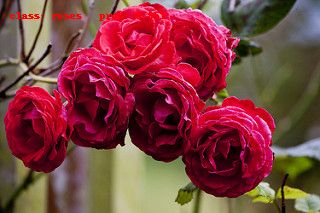

In [119]:
start_time = time.time()
sq = torch.squeeze(y).cpu()
predict = torch.softmax(sq, dim=0)
# 得到高概率的类别的索引
predict_cla = torch.argmax(predict).numpy()
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)], predict[i].detach().numpy()))
res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)], predict[predict_cla].detach().numpy())
draw = ImageDraw.Draw(image)
# 文本的左上角位置
position = (10, 10)
# fill 指定文本颜色
draw.text(position, res, fill='red')
print("可视化花费时间: " ,str(time.time()-start_time),"秒")
image

## 单独测试卷积层使用

In [48]:
c1 = np.zeros((1,512,7,7), dtype=np.float32)
for k in range(512):
    for i in range(7):
        for j in range(7):
            c1[0][k][i][j]=(feature_buf1[k*7*7+i*7+j]/pow(2,10)).astype('float32')

In [49]:
c2 = torch.from_numpy(c1)

In [50]:
c2.shape

torch.Size([1, 512, 7, 7])

In [51]:
time_now = time.time()
# x = model.featurs[1](c2)
# x = model.featurs[2](x)
# x = model.featurs[3](x)
# x = model.featurs[4](x)
# x = model.featurs[5](x)
# x = model.featurs[6](x)
# x = model.featurs[7](x)
# x = model.featurs[8](x)
# x = model.featurs[9](x)
# x = model.featurs[10](x)
# x = model.featurs[11](x)
# x = model.featurs[12](x)
# x = model.featurs[13](x)
# x = model.featurs[14](x)
# x = model.featurs[15](x)
# x = model.featurs[16](x)
# x = model.featurs[17](x)
# x = model.featurs[18](x)
# x = model.featurs[19](x)
# x = model.featurs[20](x)
# x = model.featurs[21](x)
# x = model.featurs[22](x)
# x = model.featurs[23](x)
# x = model.featurs[24](x)
# x = model.featurs[25](x)
# x = model.featurs[26](x)
# x = model.featurs[27](x)
# x = model.featurs[28](x)
# x = model.featurs[29](x)
# x = model.featurs[30](x)

x = torch.flatten(c2, start_dim=1)
print(time.time()-time_now)

x = model.classifier[0](x)
x = model.classifier[1](x)
x = model.classifier[2](x)
x = model.classifier[3](x)
x = model.classifier[4](x)
x = model.classifier[5](x)
x = model.classifier[6](x)
print(time.time()-time_now)

0.0007538795471191406
2.5729126930236816


In [52]:
# out = model.my_forward6(c2)
sq = torch.squeeze(x).cpu()
predict = torch.softmax(sq, dim=0)
# 得到高概率的类别的索引
predict_cla = torch.argmax(predict).numpy()
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)], predict[i].detach().numpy()))

class: daisy        prob: 0.000457
class: dandelion    prob: 0.0152
class: roses        prob: 0.00109
class: sunflowers   prob: 0.979
class: tulips       prob: 0.00456


# PYNQ 全连接层
## 加载硬件

In [58]:
from pynq import Overlay
from pynq import allocate
import numpy as np
import time
ol=Overlay("HardWare/dense128.bit")
ol.ip_dict
ol.download()
dense=ol.Dense_0
print("Overlay download finish");

Overlay download finish


## 定义硬件接口

In [50]:
def RunDense(dense,CHin,CHout,relu_en,feature_in,W,bias,feature_out):
    dense.write(0x10,CHin);
    dense.write(0x18,CHout);
    dense.write(0x20,relu_en);
    dense.write(0x28,feature_in.physical_address);
    dense.write(0x34,W.physical_address);
    dense.write(0x40,W.physical_address);
    dense.write(0x4c,W.physical_address);
    dense.write(0x58,W.physical_address);
    dense.write(0x64,bias.physical_address);
    dense.write(0x70,feature_out.physical_address);
    
    dense.write(0, (dense.read(0)&0x80)|0x01 );
    tp=dense.read(0)
    while not ((tp>>1)&0x1):
        tp=dense.read(0);

## 定义共享DDR区

In [51]:
# 输入输出buf
# feature_buf1=allocate(shape=(2048*64*64),cacheable=1,dtype=np.int16)
# feature_buf2=allocate(shape=(2048*64*64),cacheable=1,dtype=np.int16)

#权重
dense0_w=allocate(shape=(25088*5000),cacheable=1,dtype=np.int16)
dense3_w=allocate(shape=(4096*4096),cacheable=1,dtype=np.int16)
dense6_w=allocate(shape=(4096*5),cacheable=1,dtype=np.int16)

#偏置
dense0_b=allocate(shape=(4096),cacheable=1,dtype=np.int16)
dense3_b=allocate(shape=(4096),cacheable=1,dtype=np.int16)
dense6_b=allocate(shape=(4096),cacheable=1,dtype=np.int16)

## 保存权重和偏置到npy中

In [52]:
# np.save('dense0_w.npy', np.int16(model.classifier[0].weight.data*pow(2,10)))
# np.save('dense3_w.npy', np.int16(model.classifier[3].weight.data*pow(2,10)))
# np.save('dense6_w.npy', np.int16(model.classifier[6].weight.data*pow(2,10)))

# np.save('dense0_b.npy', np.int16(model.classifier[0].bias.data*pow(2,10)))
# np.save('dense3_b.npy', np.int16(model.classifier[3].bias.data*pow(2,10)))
# np.save('dense6_b.npy', np.int16(model.classifier[6].bias.data*pow(2,10)))

## Pytorch计算，用作测试

In [53]:
x = model.featurs[0](img)
x = model.featurs[1](x)
x = model.featurs[2](x)
x = model.featurs[3](x)
x = model.featurs[4](x)
x = model.featurs[5](x)
x = model.featurs[6](x)
x = model.featurs[7](x)
x = model.featurs[8](x)
x = model.featurs[9](x)
x = model.featurs[10](x)
x = model.featurs[11](x)
x = model.featurs[12](x)
x = model.featurs[13](x)
x = model.featurs[14](x)
x = model.featurs[15](x)
x = model.featurs[16](x)
x = model.featurs[17](x)
x = model.featurs[18](x)
x = model.featurs[19](x)
x = model.featurs[20](x)
x = model.featurs[21](x)
x = model.featurs[22](x)
x = model.featurs[23](x)
x = model.featurs[24](x)
x = model.featurs[25](x)
x = model.featurs[26](x)
x = model.featurs[27](x)
x = model.featurs[28](x)
x = model.featurs[29](x)
x = model.featurs[30](x)

tt = torch.flatten(x, start_dim=1)

x = model.classifier[0](tt)
x = model.classifier[1](x)
t1 = model.classifier[2](x)
x = model.classifier[3](t1)
x = model.classifier[4](x)
t2 = model.classifier[5](x)
x = model.classifier[6](t2)

## 加载参数

In [54]:
dense0_w_np = np.load("dense0_w.npy")
dense3_w_np = np.load("dense3_w.npy")
dense6_w_np = np.load("dense6_w.npy")

dense0_b_np = np.load("dense0_b.npy")
dense3_b_np = np.load("dense3_b.npy")
dense6_b_np = np.load("dense6_b.npy")

In [55]:
Load_Weight(dense0_w,dense0_w_np)
Load_Weight(dense3_w,dense3_w_np)
Load_Weight(dense6_w,dense6_w_np)

Load_Bias(dense0_b,dense0_b_np)
Load_Bias(dense3_b,dense3_b_np)
Load_Bias(dense6_b,dense6_b_np)

In [87]:
feature_buf1[:60]

PynqBuffer([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
             0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
             0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
             0,  0,  0,  0,  6,  9,  0,  0,  0,  0,  0,  3, 10,  0,  0],
           dtype=int16)

## FPGA加速全连接层

In [119]:
start_time = time.time()
RunDense(dense,25088,4096,1,feature_buf1,dense0_w,dense0_b,feature_buf2)
print(time.time()-start_time)

0.2228548526763916


In [120]:
start_time = time.time()
RunDense(dense,4096,4096,1,feature_buf2,dense3_w,dense3_b,feature_buf1)
print(time.time()-start_time)

0.031507253646850586


In [121]:
start_time = time.time()
RunDense(dense,4096,5,0,feature_buf1,dense6_w,dense6_b,feature_buf2)
print(time.time()-start_time)

0.0008490085601806641


## 获取输出结果

In [122]:
y = torch.zeros(1,5)
for i in range(5):
    y[0][i] = feature_buf2[i]/pow(2,10)
y

tensor([[-2.5762,  0.2178, -2.3623,  3.0469, -1.3105]])

## 结果可视化

class: daisy        prob: 0.00335
class: dandelion    prob: 0.0547
class: roses        prob: 0.00414
class: sunflowers   prob: 0.926
class: tulips       prob: 0.0119
可视化花费时间:  0.005767107009887695 秒


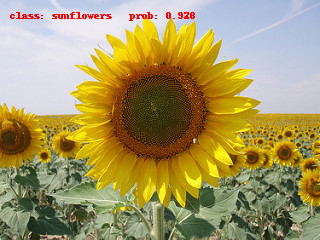

In [123]:
start_time = time.time()
sq = torch.squeeze(y).cpu()
predict = torch.softmax(sq, dim=0)
# 得到高概率的类别的索引
predict_cla = torch.argmax(predict).numpy()
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)], predict[i].detach().numpy()))
res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)], predict[predict_cla].detach().numpy())
draw = ImageDraw.Draw(image)
# 文本的左上角位置
position = (10, 10)
# fill 指定文本颜色
draw.text(position, res, fill='red')
print("可视化花费时间: " ,str(time.time()-start_time),"秒")
image